# Prompting

### **1. Instalación e importación de librerías**

Se instalan y cargan las librerías necesarias para procesamiento de lenguaje natural (`transformers`, `datasets`), modelado y entrenamiento con PyTorch (`torch`), manejo y preprocesamiento de datos (`pandas`, `scikit-learn`), y visualización (`matplotlib`, `seaborn`).
Estas herramientas permiten tanto el uso de modelos avanzados de IA como el análisis y visualización de los resultados.

In [ ]:
!pip install transformers
!pip install datasets
!pip install torch

ERROR: Operation cancelled by user


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

### **2. Montar Google Drive y definir rutas**

Se monta Google Drive para acceder a archivos de datos de entrenamiento y prueba. Se definen rutas a los archivos CSV que contienen los informes radiológicos ya preprocesados y limpios, así como los archivos de entrenamiento aumentados y de test.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **3. Carga de datos**

Se carga el conjunto principal de datos (`datos_limpios.csv`) usando pandas, lo que permite manipular los informes radiológicos y sus etiquetas en memoria para su posterior procesamiento y análisis.

In [ ]:
#root_dir = "/content/drive/MyDrive/aaa/"
root_dir = r"/content/drive/MyDrive/Proyecto-de-Grado-RAD-Alert/Oficial/Ahora-si-este-fue/data/"
#root_dir = r"/content/drive/MyDrive/"

path_df = root_dir + "datos_limpios.csv"
path_train = root_dir + "datos_limpios_aumentados_entrenamiento.csv"
path_test = root_dir + "datos_limpios_prueba.csv"

In [ ]:
df_train = pd.read_csv(path_df)

### **4. Configuración de la API de OpenAI**

Se configura el cliente de OpenAI para interactuar con modelos de lenguaje avanzados (GPT-3.5, GPT-4).
Esto permite utilizar la API de OpenAI para hacer clasificación de textos clínicos, es decir, para que un modelo de IA determine si un informe radiológico es “crítico” o “no crítico”.


### **5. Función para clasificación con OpenAI**

Se define la función `classify_openai`, que recibe un texto y le solicita a GPT que lo clasifique como **crítico (1)** o **no crítico (0)**, basándose únicamente en el contenido del informe radiológico, sin suposiciones ni explicaciones adicionales.
Esto fuerza al modelo a dar una respuesta objetiva y clara, útil para comparar su rendimiento frente a métodos tradicionales.

In [ ]:
import openai

client = openai.OpenAI(api_key="sk")

def classify_openai(text):
    prompt = (
        f"Analiza el siguiente informe radiológico escrito en español y determina si contiene hallazgos clínicos **críticos** que requieren atención médica urgente. "
        f"Un informe se considera crítico si describe condiciones potencialmente mortales, cambios agudos severos, o hallazgos que requieren una intervención inmediata. "
        f"No inventes ni asumas información adicional; basa tu decisión solo en el contenido del texto. "
        f"Responde estrictamente con un solo número: **1** si el informe es crítico, o **0** si no lo es. No añadas explicaciones ni comentarios.\n\n\"{text}\""
    )


    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",  # o "gpt-4"
            messages=[{"role": "user", "content": prompt}],
            temperature=0.4,
            max_tokens=150,
        )
        return response.choices[0].message.content.strip()

    except Exception as e:
        print("❌ Error al generar contenido con OpenAI:", e)
        return text

In [ ]:
df_train

,texto,etiqueta
0,"En equipo multidetector, se realizan cortes ax...",0
1,Se realizan cortes axiales desde fosa posterio...,0
2,"En equipo multidetector, se realizan cortes ax...",0
3,Se realizan cortes axiales desde fosa posterio...,0
4,"\nEn equipo multidetector, se realizan cortes ...",1
...,...,...
3372,"En equipo multidetector, se realizan cortes ax...",0
3373,"En equipo multidetector, se realizan cortes ax...",0
3374,"En equipo multidetector, se realizan cortes ax...",0
3375,"En equipo multidetector, se realizan cortes ax...",0


### **6. Predicción sobre todos los informes**

Se utiliza la función anterior para procesar todos los informes del DataFrame con una barra de progreso (`tqdm`).
Para cada informe, se guarda la predicción de OpenAI junto al texto y la etiqueta real.

In [ ]:
from tqdm.auto import tqdm

# Lista para guardar predicciones
predicciones = []

# Recorrer DataFrame con tqdm para barra de progreso
for _, row in tqdm(df_train.iterrows(), total=len(df_train)):
    pred = classify_openai(row["texto"])
    predicciones.append(pred)

# Agregar predicciones al DataFrame
df_train["prediccion_openai"] = predicciones


  0%|          | 0/3377 [00:00<?, ?it/s]

In [ ]:
df_train

,texto,etiqueta,prediccion_openai,acierto
0,"En equipo multidetector, se realizan cortes ax...",0,1,False
1,Se realizan cortes axiales desde fosa posterio...,0,1,False
2,"En equipo multidetector, se realizan cortes ax...",0,1,False
3,Se realizan cortes axiales desde fosa posterio...,0,0,False
4,"\nEn equipo multidetector, se realizan cortes ...",1,1,False
...,...,...,...,...
3372,"En equipo multidetector, se realizan cortes ax...",0,1,False
3373,"En equipo multidetector, se realizan cortes ax...",0,0,False
3374,"En equipo multidetector, se realizan cortes ax...",0,0,False
3375,"En equipo multidetector, se realizan cortes ax...",0,0,False


### **7. Limpieza y formateo de las predicciones**

Las predicciones se convierten a tipo numérico para asegurar que no haya problemas de formato. Se eliminan espacios en blanco y se manejan posibles valores nulos o incorrectos, garantizando que los datos estén listos para análisis.


In [ ]:
df_train['prediccion_openai'] = df_train['prediccion_openai'].astype(str).str.strip()
df_train['prediccion_openai'] = pd.to_numeric(df_train['prediccion_openai'], errors='coerce').astype('Int64')

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3377 entries, 0 to 3376
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   texto              3377 non-null   object
 1   etiqueta           3377 non-null   int64 
 2   prediccion_openai  3377 non-null   Int64 
 3   acierto            3377 non-null   bool  
dtypes: Int64(1), bool(1), int64(1), object(1)
memory usage: 85.9+ KB


df_train

### **8. Cálculo de aciertos (accuracy)**

Se crea una nueva columna (`acierto`) que indica si la predicción de OpenAI coincide con la etiqueta real.
Luego, se calcula el **accuracy** general del modelo OpenAI sobre la muestra: el porcentaje de informes correctamente clasificados como críticos o no críticos.

In [ ]:
df_train['acierto'] = df_train['prediccion_openai'] == df_train['etiqueta']

In [ ]:
# Resultados
accuracy = df_train["acierto"].mean()
print(f"\n✅ Precisión del modelo OpenAI en esta muestra: {accuracy:.2%}")


✅ Precisión del modelo OpenAI en esta muestra: 73.44%


In [ ]:
df_train['texto'][4]

'\nEn equipo multidetector, se realizan cortes axiales desde la base del cráneo hasta la convexidad, sin la administración de medio de contraste.  ALTERACION DEL ESTADO DE CONSIENCIA. Surcos y espacio subaracnoideo prominentes por pérdida de volumen cerebral.\n\nSistema ventricular supratentorial es prominente, acorde a la pérdida de volumen, con índice de Evans de 0,29.\n\nInfarto lacunar antiguo periventricular izquierdo.\n\nHipodensidades de la sustancia blanca subcortical y periventricular por cambios de lo que encefalopatía microangiopática.\n\nNo se observan líneas de fractura.\n\nLas porciones visualizadas de las orbitas, senos paranasales y mastoides no muestran alteraciones.\n\nAteromatosis calcificada de ambas arterias vertebrales y de la porción cavernosa de las arterias carótidas internas. Signos de pérdida de volumen cerebral y cambios por leucoencefalopatía microangiopática.\n\nInfarto lacunar antiguo PERIVENTRICULAr izquierdo.'

In [ ]:
conf_matrix = pd.crosstab(df_train['etiqueta'], df_train['prediccion_openai'], rownames=['Actual'], colnames=['Predicción'], dropna=False)
print(conf_matrix)

Predicción     0    1
Actual               
0           2210  877
1             20  270


### **9. Matriz de confusión**

Se construye y visualiza una matriz de confusión que muestra cuántos informes críticos/no críticos fueron clasificados correctamente o incorrectamente por el modelo de OpenAI.
Esta matriz es fundamental para entender no solo el accuracy, sino también si el modelo tiende a confundir las clases (por ejemplo, dar falsos negativos).

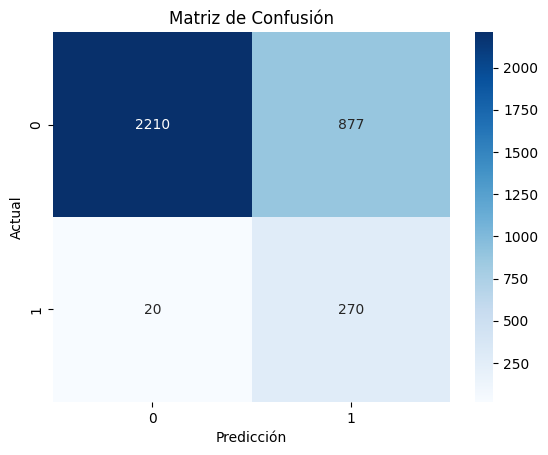

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Elimina filas con NaN si las hay
df_clean = df_train.dropna(subset=['etiqueta', 'prediccion_openai'])

cm = confusion_matrix(df_clean['etiqueta'], df_clean['prediccion_openai'])

# Visualización
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Elimina filas con NaN si es necesario
df_clean = df_train.dropna(subset=['etiqueta', 'prediccion_openai'])

# Métricas detalladas
print(classification_report(df_clean['etiqueta'], df_clean['prediccion_openai'], digits=4))

# Accuracy por separado (opcional)
accuracy = accuracy_score(df_clean['etiqueta'], df_clean['prediccion_openai'])
print(f'Accuracy: {accuracy:.4f}')

              precision    recall  f1-score   support

           0     0.9910    0.7159    0.8313      3087
           1     0.2354    0.9310    0.3758       290

    accuracy                         0.7344      3377
   macro avg     0.6132    0.8235    0.6035      3377
weighted avg     0.9261    0.7344    0.7922      3377

Accuracy: 0.7344
